# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # For Data splitting
import os
from sklearn.metrics import accuracy_score #Evaluation


# Data Preperation
## Data Loading

In [3]:
data_path = "data" # make sure to execute from project folder as pwd
df_data = pd.read_csv(os.path.join(data_path, "train.csv"))

In [4]:
df_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Class Distribution')

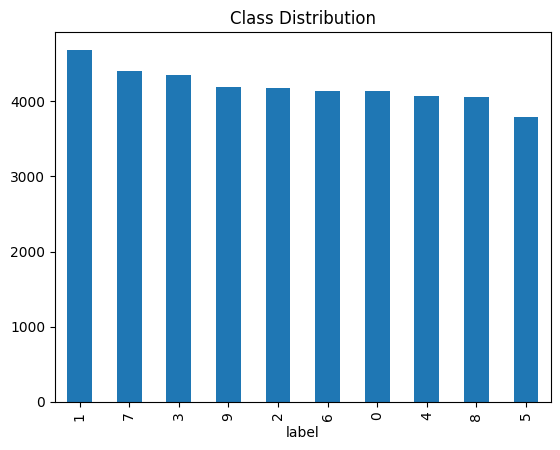

In [5]:
df_data['label'].value_counts().plot(kind='bar').set_title("Class Distribution")
#As you see not a large difference between dsitribution, thus, we can say classes are pretty good balanced
# No imbalance case, best metric to use is Accuracy, no need for precision, recall & F1

## Data Splitting to Traing & Testing
Training Data is in tabular form, with the first column `Label` being the target feature, (label of class number), the rest are columns anmes from `pixel0`...`pixel783` representing our image 28x28x1 Image (Grayscale 1 Channel)


In [6]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(df_data.drop(['label'],axis=1), df_data['label'], test_size=0.2, random_state=42) # 80% 20% split

In [7]:
#Assembling X_test with y_test in a DF to save, and use as examples later on.
X_saved = X_test_df.copy(deep=True)
X_saved["label"] = y_test_df.iloc[:]
X_saved.to_csv(os.path.join(os.path.join("data","test_gen.csv")),index=False)
X_saved.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
5457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
38509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
25536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
31803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
39863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8


In [8]:
#   Target Image properties 32 x 32 x 3, to be able to use VGG16, original data are 28x28x1 (grayscale)
n_h = n_w = 32 # target heigh, width of training
h =w=28 #original heigh,weight
n_c = 3 # number of channels target
INPUT_SHAPE = (n_h,n_w,n_c)
m_train = len(X_train_df) #number of examples train
m_test = len(X_test_df) # number of examples test
print(f"Proprties : \nTarget Image Height : {n_h}px\nTarget Image Width : {n_w}px\nTarget Number of channels : {n_c}\nTraining Data Examples : {m_train}\nTesting Data Examples : {m_test}")

Proprties : 
Target Image Height : 32px
Target Image Width : 32px
Target Number of channels : 3
Training Data Examples : 33600
Testing Data Examples : 8400


In [16]:
#images are gray scaled so pixel values from 0 - 255, repsenting white to black intensity, to make this more accuracte, we gonna duplicate to have 3 channels as we are finetunning with VGG16

## Data Pre-Processing
Applyign a number of operatiosn to make our data ready for training & preocessing (Foramt to Numpy - > Unflatten - > multiply channels to 3 - >  Padding)

In [9]:

X_train = X_train_df.to_numpy().reshape((m_train,h,w,1)) # Shape our data to correct imaeg shape (28,28,1) (Unflatten) while switching to Numpy
X_train = np.pad(X_train, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant') #This is just padding our image examples by to fro meach side, (28,28) -> (32,32), this done, cause padding is a common process, to make edges clearer, and since VGG16 low image input shape is (32,32)
X_train = np.repeat(X_train, 3, axis=-1) #turn to 3 axis (Duplicating single channel to be 3, same values), this is done cause VGG16 in particular only accepts images with 3 channels.
X_train = X_train / 255.0 # Normalize
X_test = X_test_df.to_numpy().reshape((m_test,h,w,1)) # Same thing done before, just on Testing data
X_test = np.pad(X_test, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant') #pad
X_test = np.repeat(X_test, 3, axis=-1)
X_test = X_test / 255.0 # Normalize
y_train = y_train_df.to_numpy() # Turning Y data to numpy simpely
y_test = y_test_df.to_numpy()

### Visualizing Some Examples after pre-processing

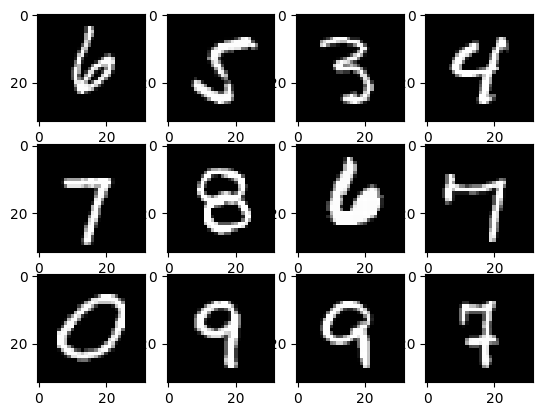

In [10]:

_, axs = plt.subplots(3,4)
axs = axs.flatten()
for i in range(12):
    axs[i].imshow(X_train[i])
plt.show()

In [11]:
# Define an image data generator for training data with data augmentation (meaning icnrease dataset examples by operations like shifting,zooming)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=27,          # Randomly rotate images by up to 27 degrees
    width_shift_range=0.3,      # Randomly shift images horizontally by up to 30% of the width
    height_shift_range=0.2,     # Randomly shift images vertically by up to 20% of the height
    shear_range=0.3,           # Randomly apply shear transformations with a shear intensity of up to 0.3
    zoom_range=0.2,            # Randomly zoom images by up to 20%
    horizontal_flip=False)      # Do not flip images horizontally, don't really want that with numbers

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator() # No Data augmentation for validation

#This generator will be calle d laetr with model fit

In [12]:
train_images, val_images, train_labels, val_labels = train_test_split(X_train,
                                                                      y_train,
                                                                      test_size=0.1, train_size=0.9,
                                                                      shuffle=True,
                                                                      random_state=44)
# Training,Validation Split,10% is taken sicne 33,600 data is available, without oversampling
print(f"Training Data Examples : {len(train_labels)}\nValidation Data Examples : {len(val_labels)}")

Training Data Examples : 30240
Validation Data Examples : 3360


# Model Building for VGG 19 Base Model
You didn't really think, I'll stop at 1 model?

In [13]:
pre_model = tf.keras.applications.VGG19(input_shape=INPUT_SHAPE,include_top=False,weights="imagenet") # Loading VGG 19 as premodel to finetune

In [14]:
for layer in pre_model.layers[:17]:
    layer.trainable = False

for layer in pre_model.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<Conv2D name=block3_conv4, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<Conv2D name=block4_conv4, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> True
<Conv2D name=block5_conv2, built=True> True
<Conv2D name=block5_conv3, built=True> True
<Conv2D name=block5_conv4, built=True> True
<MaxPooling2D name=block5_pool, buil

In [15]:
pre_model.summary() #OF VGG19

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 9,439,232 (36.01 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

In [16]:
# Did sequentiel before, but had a bug with serializaion
input_tensor = tf.keras.Input(shape=INPUT_SHAPE)
x = pre_model(input_tensor)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=1024, activation='relu')(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)
x = tf.keras.layers.Dense(units=32, activation='relu')(x)
output_tensor = tf.keras.layers.Dense(units=10, activation='softmax')(x)

model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)


# Now this is architecture to use, output layer is clearly a 10 output Dense layer with softmax, cause we're in buisness of multi-classification
# There was no need for reglurization, as no overfitting was observed

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss='sparse_categorical_crossentropy', #Loss function due multi-classification
              metrics=["accuracy"]
             )

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,617,706 (78.65 MB)

 Trainable params: 10,032,554 (38.27 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

# Model VGG-19 Based Training Phase 🏋️‍♂️

In [19]:
history = model.fit(train_datagen.flow(train_images,train_labels, batch_size=200), # Datagen called, batch_size = 200, 50 pass by data (epoch)
                         steps_per_epoch=train_images.shape[0] // 200,
                         epochs=50 ,
                         validation_data=val_datagen.flow(val_images,val_labels,
                                                                 batch_size=200
                        ))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 54s 266ms/step - accuracy: 0.2687 - loss: 2.0280 - val_accuracy: 0.8429 - val_loss: 0.4505
Epoch 2/20
  1/151 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7650 - loss: 0.5970

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7650 - loss: 0.5970 - val_accuracy: 0.8289 - val_loss: 0.4617
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 31s 196ms/step - accuracy: 0.8469 - loss: 0.4699 - val_accuracy: 0.9452 - val_loss: 0.1773
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9200 - loss: 0.3009 - val_accuracy: 0.9310 - val_loss: 0.2181
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.9154 - loss: 0.2902 - val_accuracy: 0.9661 - val_loss: 0.1147
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9450 - loss: 0.1770 - val_accuracy: 0.9673 - val_loss: 0.1183
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.9296 - loss: 0.2352 - val_accuracy: 0.9542 - val_loss: 0.1653
Epoch 8/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9300 - loss: 0.2270 - val_accuracy: 0.9634 - val_loss: 0.1341
Epoch 9/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 33s 213ms/step - accuracy: 0.9418 - loss: 0.1998 - val_accuracy: 0

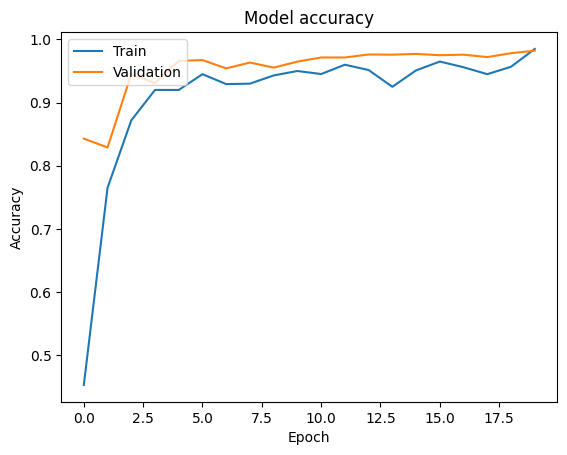

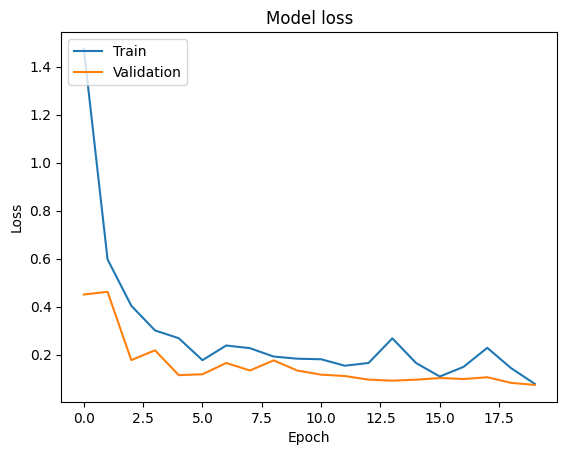

In [20]:

# Assuming you have already trained your model and stored the history
# e.g., history = model.fit(..., epochs=10, validation_data=(...))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model VGG-19 Based Evaluation on Test Set
97.75% Accuracy

In [21]:
model.evaluate(X_test,y_test)

263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9750 - loss: 0.0831


[0.07794935256242752, 0.9767857193946838]

# Model 2 Building (ResNET 50 Transfer Learning)

In [22]:
pre_model_2 = tf.keras.applications.ResNet50(input_shape=INPUT_SHAPE,include_top=False,weights="imagenet")

In [23]:
for layer in pre_model_2.layers:
    print(layer, layer.trainable) #to make it more dynamic this project how about we finetune the whole layers, for more task adaption

<InputLayer name=input_layer_2, built=True> True
<ZeroPadding2D name=conv1_pad, built=True> True
<Conv2D name=conv1_conv, built=True> True
<BatchNormalization name=conv1_bn, built=True> True
<Activation name=conv1_relu, built=True> True
<ZeroPadding2D name=pool1_pad, built=True> True
<MaxPooling2D name=pool1_pool, built=True> True
<Conv2D name=conv2_block1_1_conv, built=True> True
<BatchNormalization name=conv2_block1_1_bn, built=True> True
<Activation name=conv2_block1_1_relu, built=True> True
<Conv2D name=conv2_block1_2_conv, built=True> True
<BatchNormalization name=conv2_block1_2_bn, built=True> True
<Activation name=conv2_block1_2_relu, built=True> True
<Conv2D name=conv2_block1_0_conv, built=True> True
<Conv2D name=conv2_block1_3_conv, built=True> True
<BatchNormalization name=conv2_block1_0_bn, built=True> True
<BatchNormalization name=conv2_block1_3_bn, built=True> True
<Add name=conv2_block1_add, built=True> True
<Activation name=conv2_block1_out, built=True> True
<Conv2D name

In [24]:
pre_model_2.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [29]:

input_tensor = tf.keras.Input(shape=INPUT_SHAPE)

x = pre_model_2(input_tensor)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=1024, activation='relu')(x)
x = tf.keras.layers.Dense(units=64, activation='relu')(x)

output_tensor = tf.keras.layers.Dense(units=10, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

In [30]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss='sparse_categorical_crossentropy',
              metrics=["accuracy"]
             )

In [31]:
model_2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,752,138 (98.24 MB)

 Trainable params: 25,699,018 (98.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Model ResNET50 Based Training Phase 🏋️‍♂️

In [32]:
history_2 = model_2.fit(train_datagen.flow(train_images,train_labels, batch_size=200),
                         steps_per_epoch=train_images.shape[0] // 200,
                         epochs=50,
                         validation_data=val_datagen.flow(val_images,val_labels,
                                                                 batch_size=200
                        ))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 140s 446ms/step - accuracy: 0.6944 - loss: 0.9842 - val_accuracy: 0.1063 - val_loss: 12.1846
Epoch 2/50
  1/151 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.9450 - loss: 0.1649

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9450 - loss: 0.1649 - val_accuracy: 0.1063 - val_loss: 12.2339
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 78s 233ms/step - accuracy: 0.9475 - loss: 0.1917 - val_accuracy: 0.1063 - val_loss: 6.5133
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9550 - loss: 0.1649 - val_accuracy: 0.1063 - val_loss: 6.7433
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 42s 242ms/step - accuracy: 0.9565 - loss: 0.1586 - val_accuracy: 0.1720 - val_loss: 3.2530
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9450 - loss: 0.1750 - val_accuracy: 0.1690 - val_loss: 3.3765
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - accuracy: 0.9630 - loss: 0.1345 - val_accuracy: 0.4917 - val_loss: 1.7743
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9550 - loss: 0.1262 - val_accuracy: 0.4973 - val_loss: 1.7534
Epoch 9/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 28s 176ms/step - accuracy: 0.9675 - loss: 0.1183 - val_accuracy: 

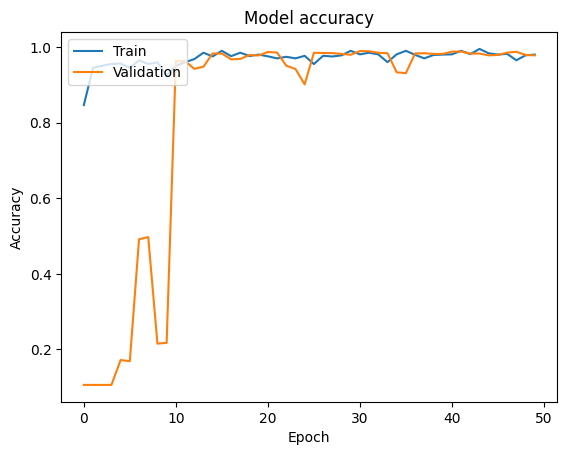

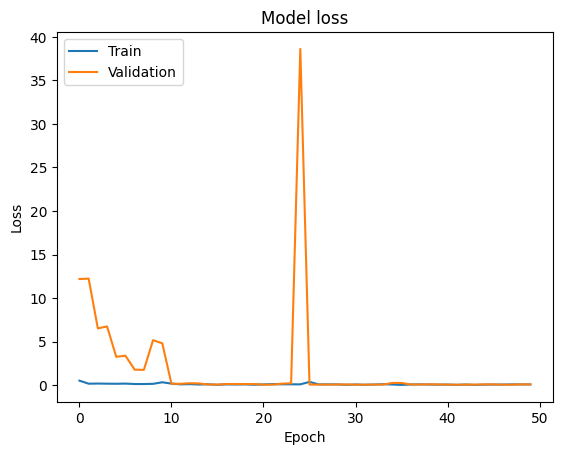

In [33]:
# Plot training & validation accuracy values
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model VGG-19 Based Evaluation
98.05% Accuracy

In [34]:
model_2.evaluate(X_test,y_test)

263/263 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.9774 - loss: 0.0739


[0.06940983980894089, 0.9805952310562134]

# Ensembeling Models
This method is about 'instead of choosing one model over other', we ensemble them, and average their prediction, in the hopes that thses models will help each outher doubteness and weaknesses in certain cases, to improve accuracy

In [35]:
predictions_1 = model.predict(X_test)
predictions_2 = model_2.predict(X_test)
predictions = (predictions_1 + predictions_2) / 2
y_pred = [np.argmax(pred) for pred in predictions]

263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step


### Evaluation
Acccuracy : 99.0%

In [36]:
accuracy_score(y_test,y_pred)

0.99

# Saving Models in Keras FORMAT
TO be used by a specifiel model class later on, on deployment side of things, code is available on `model.py`

In [37]:
model.save("models/VGG19.keras")
model_2.save("models/RESNET50.keras")

# Extra analysis on Where model went wrong
### Confusion Matrix
Errors are little, and usually between close in shape numbers (8,9) (7,1) where we humans make misatke too in handwritten

c:\Projects\Ai school\notebooks
Image is already normalized.
263/263 ━━━━━━━━━━━━━━━━━━━━ 111s 420ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step


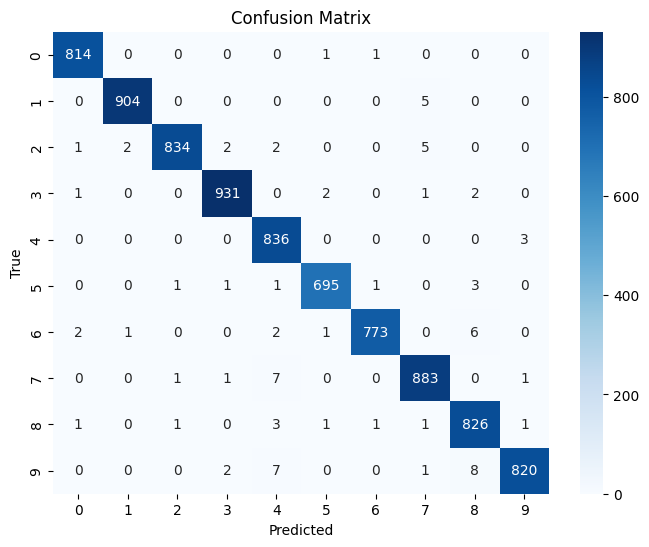

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../') # Necessary for finding model & utils
from src.model import EnsembledModel # Our Defined Ensembled methods
from src.utils import csv_to_numpy
model = EnsembledModel(models_path="../models")
X_test,y_test = csv_to_numpy("../data/test_gen.csv")
cm = model.cm(X_test,y_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Some Visualization on model prediction

Image is already normalized.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


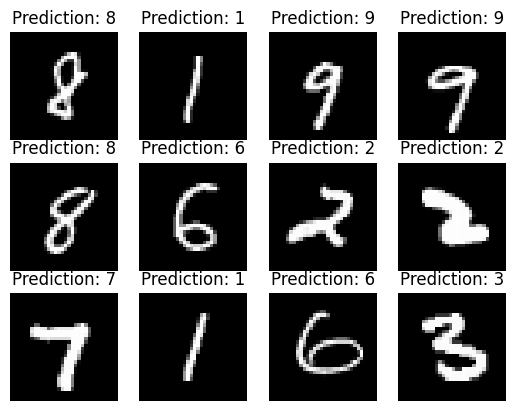

In [ ]:
from src.model import EnsembledModel # Our Defined Ensembled methods
from src.utils import csv_to_numpy
X,y = csv_to_numpy("../data/test_gen.csv") # method defined to help us, in loading csv straight to X,y
model = EnsembledModel(models_path="../models")
model.predict_visualize(X[:12])